
**Install requirements**

In [0]:
"""!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'"""

"!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'"

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

# provided .py file
import torch.nn as nn
from torch.autograd import Function
from torch.hub import load_state_dict_from_url
import copy
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 # 7 classes, 4 domains

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 15      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

# This is the weight of the reversed backpropagation, and must be optimized as an hyperparameter of the algorithm
ALPHA = None

# Use domain adaptation during training? True, False
DOMAIN_ADAPTATION = True

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
# Basic transformation to apply to the images loaded from the dataset
basic_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                              
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS

PHOTO_DIR = 'Homework3-PACS/PACS/photo' # Photo is the src domain
ART_DIR = 'Homework3-PACS/PACS/art_painting' # Art is the target domain 
CARTOON_DIR = 'Homework3-PACS/PACS/cartoon'
SKETCH_DIR = 'Homework3-PACS/PACS/sketch' 

# You can easily read each domain as a PyTorch dataset using the ImageFolder class
photo_dataset = torchvision.datasets.ImageFolder(PHOTO_DIR, transform=basic_transform)
art_dataset = torchvision.datasets.ImageFolder(ART_DIR, transform=basic_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(CARTOON_DIR, transform=basic_transform)
sketch_dataset = torchvision.datasets.ImageFolder(SKETCH_DIR, transform=basic_transform)

print('Photo Dataset: {}'.format(len(photo_dataset)))
print('Art Dataset: {}'.format(len(art_dataset)))
print('Cartoon Dataset: {}'.format(len(cartoon_dataset)))
print('Sketch Dataset: {}'.format(len(sketch_dataset)))

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 40.85 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.
Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


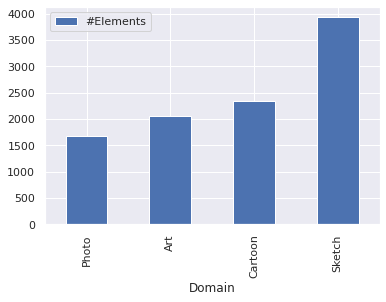

In [0]:
df = pd.DataFrame({'Domain':['Photo', 'Art', 'Cartoon', 'Sketch'], '#Elements':[len(photo_dataset), len(art_dataset), len(cartoon_dataset), len(sketch_dataset) ]})
ax = df.plot(kind = 'bar',x='Domain', y='#Elements')

**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
# Loaders associated to the previous defined datasets
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

**Implementing the model**

In [0]:
# point 2
# Original implementations of DANN already exists in public PyTorch repositories
# i'm modifying alexnet accordingly

# in this block i'm putting together:
# - alexnet default implementation, https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
# - provided gradient reversal, https://github.com/MachineLearning2020/Homework3-PACS/blob/master/gradient_reversal_example.py
# => result: DANN network

model_urls = \
{
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
  # Forwards identity
  # Sends backward reversed gradients
  @staticmethod
  def forward(ctx, x, alpha):
      ctx.alpha = alpha

      return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
      output = grad_output.neg() * ctx.alpha

      return output, None

# AlexNet upgrade => DANN
class DANN(nn.Module):
    # To implement Gd, you have to modify the init function of AlexNet, and add the new branch
    def __init__(self, num_classes=1000):
        super(DANN, self).__init__()
        self.features = nn.Sequential( # Gf
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential( #FC MAIN CLASSIFIER - Gy
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )
        # Basically, you have to add a new densely connected branch with 2 output neurons
        self.GD = nn.Sequential( #FC DOMAIN CLASSIFIER (This is the update to the standard AlexNet) - Gd
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2), # 2 classes, binary classifier
        )


    def forward(self, x, alpha=None):
        features = self.features(x)
        # Flatten the features:
        features = features.view(features.size(0), -1)
        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(features, alpha)
            discriminator_output = self.GD(reverse_feature)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            class_outputs = self.classifier(features)
            return class_outputs


def dann(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = DANN(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'], progress=progress)       
        model.load_state_dict(state_dict, strict=False) #If you create a new branch in the init function, and try to preload weights into the original branches, it gives you an error
                                                        # Use the flag strict=False in the load_state_dict function to avoid this error
        # modify gd
        model.GD[1].weight.data = copy.deepcopy(model.classifier[1].weight.data)
        model.GD[1].bias.data = copy.deepcopy(model.classifier[1].bias.data)
        model.GD[4].weight.data = copy.deepcopy(model.classifier[4].weight.data)
        model.GD[4].bias.data = copy.deepcopy(model.classifier[4].bias.data)   
    return model

**Prepare network (uncomment for points 3a, 3b)**

In [0]:
train_dataloader = photo_dataloader
test_dataloader = art_dataloader

"""net = dann(pretrained = True) # Loading our AlexNet customized pretrained  model
bestnet =  dann(pretrained = True) # keep track of the best model during the iteration (consider losses)

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 7 outputs for PACS

# modify last layer of alexnet
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
bestnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)                                             

# We just changed the last layer of AlexNet with a new fully connected layer with 7 outputs
# It is mandatory to study torchvision.models.alexnet source code

"""

"net = dann(pretrained = True) # Loading our AlexNet customized pretrained  model\nbestnet =  dann(pretrained = True) # keep track of the best model during the iteration (consider losses)\n\n# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes\n# We need 7 outputs for PACS\n\n# modify last layer of alexnet\nnet.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer\n                                                 # The convolutional layer is nn.Conv2d\nbestnet.classifier[6] = nn.Linear(4096, NUM_CLASSES)                                             \n\n# We just changed the last layer of AlexNet with a new fully connected layer with 7 outputs\n# It is mandatory to study torchvision.models.alexnet source code\n\n"

**Prepare Training (uncomment for points 3a, 3b)**

In [0]:
"""# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
bestnet_parameters_to_optimize = bestnet.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
bestnet_optimizer = optim.SGD(bestnet_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
bestnet_scheduler = optim.lr_scheduler.StepLR(bestnet_optimizer, step_size=STEP_SIZE, gamma=GAMMA)"""

"# Define loss function\ncriterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy\n\n# Choose parameters to optimize\n# To access a different set of parameters, you have to access submodules of AlexNet\n# (nn.Module objects, like AlexNet, implement the Composite Pattern)\n# e.g.: parameters of the fully connected layers: net.classifier.parameters()\n# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) \nparameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet\nbestnet_parameters_to_optimize = bestnet.parameters()\n\n# Define optimizer\n# An optimizer updates the weights based on loss\n# We use SGD with momentum\noptimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\nbestnet_optimizer = optim.SGD(bestnet_parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\n\n# Define scheduler\n# A scheduler dynamically changes learning rate

**Point 4 support**

In [0]:
def instantiateNewNet(NUM_EPOCHS, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION):
  net = dann(pretrained = True) # Loading our AlexNet customized pretrained  model

  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  # We need 7 outputs for PACS

  # modify last layer of alexnet
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                  # The convolutional layer is nn.Conv2d

  # We just changed the last layer of AlexNet with a new fully connected layer with 7 outputs
  # It is mandatory to study torchvision.models.alexnet source code

  # Define loss function
  criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

  # Choose parameters to optimize
  # To access a different set of parameters, you have to access submodules of AlexNet
  # (nn.Module objects, like AlexNet, implement the Composite Pattern)
  # e.g.: parameters of the fully connected layers: net.classifier.parameters()
  # e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

  # Define optimizer
  # An optimizer updates the weights based on loss
  # We use SGD with momentum
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

  # Define scheduler
  # A scheduler dynamically changes learning rate
  # The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  bestnet = training(net,criterion, NUM_EPOCHS, scheduler, optimizer, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
  return bestnet, optimizer, criterion

**Test**

In [0]:
def test(net, test_dataloader, test_dataset, optimizer, criterion):
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  running_loss = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    optimizer.zero_grad()
    loss = criterion(outputs, labels)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_loss += loss.item()*images.size(0)
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataset))
  loss = running_loss / float(len(test_dataset))

  print('Test Accuracy: {}'.format(accuracy))
  print('Test Loss: {}'.format(loss))
  return accuracy, loss

In [0]:
def output(epochs_list, losses, losses_discriminator_source, losses_discriminator_target):
  epochsLosses = list(zip(epochs_list, losses, losses_discriminator_source, losses_discriminator_target))
  dataEpochsLosses = pd.DataFrame(epochsLosses, columns = ['Epochs', 'Loss', 'Loss discr. src', 'Loss discr. target'])
  ax1 = sns.lineplot(x="Epochs", y="Loss", data=dataEpochsLosses)
  ax1 = sns.lineplot(x="Epochs", y="Loss discr. src", data=dataEpochsLosses)
  ax1 = sns.lineplot(x="Epochs", y="Loss discr. target", data=dataEpochsLosses)
  ax1.legend(['Loss','Loss discr. src', 'Loss discr. target'])
  ax1.set(xlabel='Epochs', ylabel='Loss')
  plt.show()

In [0]:
# common function
def training(net,criterion, NUM_EPOCHS, scheduler, optimizer, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION):
  bestnet = copy.deepcopy(net)

  # i will iterate following the max number of batches
  # so each dataset is iterated entirely at least once
  nr_batches = max(len(train_dataloader), len(target_dataloader))
  
  # By default, everything is loaded to cpu
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  epochs_list = []
  losses = []
  losses_discriminator_source = []
  losses_discriminator_target = []

  best_loss = float('inf')

  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    epochs_list.append(epoch)
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    # Iterate over the dataset
    index = 0
    while index < nr_batches:
      
      net.train() # Sets module in training mode
      
      # supervised learning of photos
      source_images, source_labels = next(iter(train_dataloader))
      source_images = source_images.to(DEVICE)
      source_labels = source_labels.to(DEVICE)   

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Divide a single training iteration in three steps that you execute sequentially before calling optimizer.step()
      # step1 - train on source labels by forwarding source data to Gy, get the loss, and update gradients with loss.backward()
      outputs = net(source_images)
      loss = criterion(outputs, source_labels)
      loss.backward()  # backward pass: computes gradients

      if DOMAIN_ADAPTATION:
        # unsupervised learning of art (no labels)
        target_images, target_labels = next(iter(target_dataloader))
        target_images = target_images.to(DEVICE)  
        
        # step2 - train the discriminator by forwarding source data to Gd, get the loss (the label is 0 for all data), and update gradients with loss.backward()
        outputs = net.forward(source_images, alpha=ALPHA) # by spcecifying alpha i know that i'm using the Gd part (see implemented class)      
        labels_discriminator_source = torch.zeros(BATCH_SIZE, dtype=torch.int64).to(DEVICE)
        loss_discriminator_source = criterion(outputs, labels_discriminator_source)           
        loss_discriminator_source.backward()
        
        # step3 - train the discriminator by forwarding target data to Gd, get the loss (the label is 1), and update gradients with loss.backward()
        outputs = net.forward(target_images, alpha=ALPHA)           
        labels_discriminator_target = torch.ones(BATCH_SIZE, dtype=torch.int64).to(DEVICE) 
        loss_discriminator_target = criterion(outputs, labels_discriminator_target)       
        loss_discriminator_target.backward()  

        losses_discriminator_source.append(loss_discriminator_source.item())
        losses_discriminator_target.append(loss_discriminator_target.item())

      # shoud i update my best model?
      # i choose based on accuracy and loss (in this order)

      if loss.item() < best_loss:
        best_loss = loss.item()
        bestnet = copy.deepcopy(net) 

      losses.append(loss.item())
    
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1
      index = index + 1

    # Step the scheduler
    scheduler.step() 

  # to optimize
  #if DOMAIN_ADAPTATION:
  #  output(epochs_list, losses, losses_discriminator_source, losses_discriminator_target)
  return bestnet

**Point 3A**

In [0]:
"""# setting 3A
train_dataloader = photo_dataloader
test_dataloader = art_dataloader
target_dataloader = art_dataloader

# train 3A
DOMAIN_ADAPTATION = False
training(net,bestnet,criterion, NUM_EPOCHS, scheduler, optimizer, train_dataloader,test_dataloader, target_dataloader, DOMAIN_ADAPTATION)

# test 3A
test(bestnet, test_dataloader, art_dataset)"""

'# setting 3A\ntrain_dataloader = photo_dataloader\ntest_dataloader = art_dataloader\ntarget_dataloader = art_dataloader\n\n# train 3A\nDOMAIN_ADAPTATION = False\ntraining(net,bestnet,criterion, NUM_EPOCHS, scheduler, optimizer, train_dataloader,test_dataloader, target_dataloader, DOMAIN_ADAPTATION)\n\n# test 3A\ntest(bestnet, test_dataloader, art_dataset)'

**Point 3B**

In [0]:
"""# setting 3B
train_dataloader = photo_dataloader
test_dataloader = art_dataloader
target_dataloader = art_dataloader

# train 3B
DOMAIN_ADAPTATION = True
training(net,bestnet,criterion, NUM_EPOCHS, scheduler, optimizer, train_dataloader,test_dataloader, target_dataloader, DOMAIN_ADAPTATION)

# test 3B
test(bestnet, test_dataloader, art_dataset)"""

'# setting 3B\ntrain_dataloader = photo_dataloader\ntest_dataloader = art_dataloader\ntarget_dataloader = art_dataloader\n\n# train 3B\nDOMAIN_ADAPTATION = True\ntraining(net,bestnet,criterion, NUM_EPOCHS, scheduler, optimizer, train_dataloader,test_dataloader, target_dataloader, DOMAIN_ADAPTATION)\n\n# test 3B\ntest(bestnet, test_dataloader, art_dataset)'

In [0]:
# 4 - extra
# Cross domain validation
train_dataloader = photo_dataloader
test_dataloader = art_dataloader

**Point 4a**

In [0]:
def outputAccuracies(steps, accuraciesMean, accuraciesSketch, accuraciesCartoon):
  stepsAccuracies = list(zip(steps, accuraciesMean, accuraciesSketch, accuraciesCartoon))
  dataStepsAccuracies = pd.DataFrame(stepsAccuracies, columns = ['Steps', 'Mean Accuracy', 'Sketch accuracy', 'Cartoon accuracy'])
  ax1 = sns.lineplot(x="Steps", y="Mean Accuracy", data=dataStepsAccuracies)
  ax1 = sns.lineplot(x="Steps", y="Sketch accuracy", data=dataStepsAccuracies)
  ax1 = sns.lineplot(x="Steps", y="Cartoon accuracy", data=dataStepsAccuracies)
  ax1.legend(['Mean Accuracy','Sketch accuracy', 'Cartoon accuracy'])
  ax1.set(xlabel='Steps', ylabel='Accuracy')
  plt.show()

def outputLosses(steps, lossesMean, lossesSketch, lossesCartoon):
  stepsLosses = list(zip(steps, lossesMean, lossesSketch, lossesCartoon))
  dataStepsLosses = pd.DataFrame(stepsLosses, columns = ['Steps', 'Mean Loss', 'Sketch Loss', 'Cartoon Loss'])
  ax1 = sns.lineplot(x="Steps", y="Mean Loss", data=dataStepsLosses)
  ax1 = sns.lineplot(x="Steps", y="Sketch Loss", data=dataStepsLosses)
  ax1 = sns.lineplot(x="Steps", y="Cartoon Loss", data=dataStepsLosses)
  ax1.legend(['Mean Loss','Sketch Loss', 'Cartoon Loss'])
  ax1.set(xlabel='Steps', ylabel='Loss')
  plt.show()

In [0]:
LRs = [1e-2, 0.005, 1e-3]
WEIGHT_DECAYs = [5e-5, 5e-4]
STEP_SIZEs = [10, 14]

best_Accuracy = -1 # i will test the best scoring net, in terms of accuracy, on art
best_hparameters = (0, 0, 0)

accuraciesCartoon = []
accuraciesSketch = []
accuraciesMean = []

lossesCartoon = []
lossesSketch = []
lossesMean = []


steps = []
step = 0
for LR in LRs:
  for WEIGHT_DECAY in WEIGHT_DECAYs:
    for STEP_SIZE in STEP_SIZEs:
      # 4A  => find the best parameters!
      # without domain adaptation i do not need to train 2 nets,
      # yet i just have to test the same net against the 2 targets 
      # => target dataloader is not actually used if not in the test!
      DOMAIN_ADAPTATION = False

      target_dataloader = cartoon_dataloader
      bestnet, optimizer, criterion = instantiateNewNet(NUM_EPOCHS, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
      cartoonAccuracy, cartoonLoss = test(bestnet, target_dataloader, cartoon_dataset, optimizer, criterion)
      target_dataloader = sketch_dataloader
      sketchAccuracy, sketchLoss = test(bestnet, target_dataloader, sketch_dataset, optimizer, criterion)
      meanAccuracy = (cartoonAccuracy + sketchAccuracy)/2
      meanLoss = (cartoonLoss + sketchLoss)/2
      if meanAccuracy > best_Accuracy:
        best_Accuracy = meanAccuracy
        best_hparameters = (LR, WEIGHT_DECAY, STEP_SIZE)
      print("\nDEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): {}".format((LR, WEIGHT_DECAY,STEP_SIZE)))
      print("\nDEBUG:\nCartoon accuracy: {}\n Sketch accuracy: {}\n Mean accuracy: {}".format(cartoonAccuracy, sketchAccuracy, meanAccuracy))

      steps.append(step)
      accuraciesMean.append(meanAccuracy)
      accuraciesSketch.append(sketchAccuracy)
      accuraciesCartoon.append(cartoonAccuracy)

      lossesMean.append(meanLoss)
      lossesSketch.append(sketchLoss)
      lossesCartoon.append(cartoonLoss)
      step = step + 1

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/15, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Starting epoch 2/15, LR = [0.01]
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Starting epoch 7/15, LR = [0.01]
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.0001]
Starting epoch 12/15, LR = [0.001]
Starting epoch 13/15, LR = [0.001]
Starting epoch 14/15, LR = [0.001]
Starting epoch 15/15, LR = [0.001]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2295221843003413
Test Loss: 6.89055407006586


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Test Accuracy: 0.26851616187325017
Test Loss: 3.600012604715139

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.01, 5e-05, 10)

DEBUG:
Cartoon accuracy: 0.2295221843003413
 Sketch accuracy: 0.26851616187325017
 Mean accuracy: 0.24901917308679572
Starting epoch 1/15, LR = [0.01]
Starting epoch 2/15, LR = [0.01]
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Starting epoch 7/15, LR = [0.01]
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Starting epoch 12/15, LR = [0.01]
Starting epoch 13/15, LR = [0.01]
Starting epoch 14/15, LR = [0.01]
Starting epoch 15/15, LR = [0.0001]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2743174061433447
Test Loss: 7.306622762322019


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Test Accuracy: 0.3130567574446424
Test Loss: 3.707729185225248

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.01, 5e-05, 14)

DEBUG:
Cartoon accuracy: 0.2743174061433447
 Sketch accuracy: 0.3130567574446424
 Mean accuracy: 0.29368708179399355
Starting epoch 1/15, LR = [0.01]
Starting epoch 2/15, LR = [0.01]
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Starting epoch 7/15, LR = [0.01]
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.0001]
Starting epoch 12/15, LR = [0.001]
Starting epoch 13/15, LR = [0.001]
Starting epoch 14/15, LR = [0.001]
Starting epoch 15/15, LR = [0.001]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2137372013651877
Test Loss: 8.414086247466937


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Test Accuracy: 0.22168490710104352
Test Loss: 4.396588487399386

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.01, 0.0005, 10)

DEBUG:
Cartoon accuracy: 0.2137372013651877
 Sketch accuracy: 0.22168490710104352
 Mean accuracy: 0.2177110542331156
Starting epoch 1/15, LR = [0.01]
Starting epoch 2/15, LR = [0.01]
Starting epoch 3/15, LR = [0.01]
Starting epoch 4/15, LR = [0.01]
Starting epoch 5/15, LR = [0.01]
Starting epoch 6/15, LR = [0.01]
Starting epoch 7/15, LR = [0.01]
Starting epoch 8/15, LR = [0.01]
Starting epoch 9/15, LR = [0.01]
Starting epoch 10/15, LR = [0.01]
Starting epoch 11/15, LR = [0.01]
Starting epoch 12/15, LR = [0.01]
Starting epoch 13/15, LR = [0.01]
Starting epoch 14/15, LR = [0.01]
Starting epoch 15/15, LR = [0.0001]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.27303754266211605
Test Loss: 7.5957178109335


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Test Accuracy: 0.30440315601934337
Test Loss: 4.077380725280964

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.01, 0.0005, 14)

DEBUG:
Cartoon accuracy: 0.27303754266211605
 Sketch accuracy: 0.30440315601934337
 Mean accuracy: 0.2887203493407297
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2606655290102389
Test Loss: 6.28274744443926


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Test Accuracy: 0.302876049885467
Test Loss: 2.6039981429405143

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.005, 5e-05, 10)

DEBUG:
Cartoon accuracy: 0.2606655290102389
 Sketch accuracy: 0.302876049885467
 Mean accuracy: 0.28177078944785294
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [0.005]
Starting epoch 12/15, LR = [0.005]
Starting epoch 13/15, LR = [0.005]
Starting epoch 14/15, LR = [0.005]
Starting epoch 15/15, LR = [5e-05]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2794368600682594
Test Loss: 6.249131811356788


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Test Accuracy: 0.3196742173581064
Test Loss: 2.7558708084118098

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.005, 5e-05, 14)

DEBUG:
Cartoon accuracy: 0.2794368600682594
 Sketch accuracy: 0.3196742173581064
 Mean accuracy: 0.2995555387131829
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2815699658703072
Test Loss: 5.509434774874014


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Test Accuracy: 0.30465767370832275
Test Loss: 2.8746628541623584

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.005, 0.0005, 10)

DEBUG:
Cartoon accuracy: 0.2815699658703072
 Sketch accuracy: 0.30465767370832275
 Mean accuracy: 0.29311381978931494
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [0.005]
Starting epoch 12/15, LR = [0.005]
Starting epoch 13/15, LR = [0.005]
Starting epoch 14/15, LR = [0.005]
Starting epoch 15/15, LR = [5e-05]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.26493174061433444
Test Loss: 6.806642812266691


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Test Accuracy: 0.3003308729956732
Test Loss: 3.109296410828336

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.005, 0.0005, 14)

DEBUG:
Cartoon accuracy: 0.26493174061433444
 Sketch accuracy: 0.3003308729956732
 Mean accuracy: 0.2826313068050038
Starting epoch 1/15, LR = [0.001]
Starting epoch 2/15, LR = [0.001]
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Starting epoch 7/15, LR = [0.001]
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [1e-05]
Starting epoch 12/15, LR = [0.0001]
Starting epoch 13/15, LR = [0.0001]
Starting epoch 14/15, LR = [0.0001]
Starting epoch 15/15, LR = [0.0001]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.23506825938566553
Test Loss: 4.067062508124134


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Test Accuracy: 0.23593789768388904
Test Loss: 2.8985430415758624

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.001, 5e-05, 10)

DEBUG:
Cartoon accuracy: 0.23506825938566553
 Sketch accuracy: 0.23593789768388904
 Mean accuracy: 0.23550307853477728
Starting epoch 1/15, LR = [0.001]
Starting epoch 2/15, LR = [0.001]
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Starting epoch 7/15, LR = [0.001]
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Starting epoch 12/15, LR = [0.001]
Starting epoch 13/15, LR = [0.001]
Starting epoch 14/15, LR = [0.001]
Starting epoch 15/15, LR = [1e-05]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2150170648464164
Test Loss: 4.395425894154624


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Test Accuracy: 0.20386866887248664
Test Loss: 2.4595300718614785

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.001, 5e-05, 14)

DEBUG:
Cartoon accuracy: 0.2150170648464164
 Sketch accuracy: 0.20386866887248664
 Mean accuracy: 0.20944286685945152
Starting epoch 1/15, LR = [0.001]
Starting epoch 2/15, LR = [0.001]
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Starting epoch 7/15, LR = [0.001]
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [1e-05]
Starting epoch 12/15, LR = [0.0001]
Starting epoch 13/15, LR = [0.0001]
Starting epoch 14/15, LR = [0.0001]
Starting epoch 15/15, LR = [0.0001]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.2930887372013652
Test Loss: 3.6695699594126627


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Test Accuracy: 0.24051921608551793
Test Loss: 2.231752336889953

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.001, 0.0005, 10)

DEBUG:
Cartoon accuracy: 0.2930887372013652
 Sketch accuracy: 0.24051921608551793
 Mean accuracy: 0.2668039766434416
Starting epoch 1/15, LR = [0.001]
Starting epoch 2/15, LR = [0.001]
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Starting epoch 7/15, LR = [0.001]
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Starting epoch 12/15, LR = [0.001]
Starting epoch 13/15, LR = [0.001]
Starting epoch 14/15, LR = [0.001]
Starting epoch 15/15, LR = [1e-05]


  0%|          | 0/15 [00:00<?, ?it/s]

Test Accuracy: 0.21715017064846417
Test Loss: 4.602202431740614


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]

Test Accuracy: 0.18376177144311528
Test Loss: 3.015196837369162

DEBUG: parameters tested (LR, WEIGHT_DECAY, STEP_SIZE): (0.001, 0.0005, 14)

DEBUG:
Cartoon accuracy: 0.21715017064846417
 Sketch accuracy: 0.18376177144311528
 Mean accuracy: 0.20045597104578972


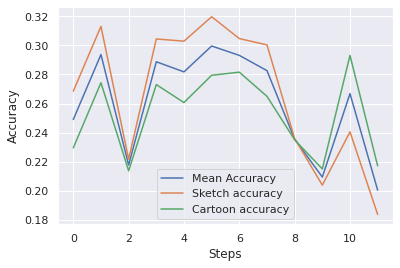

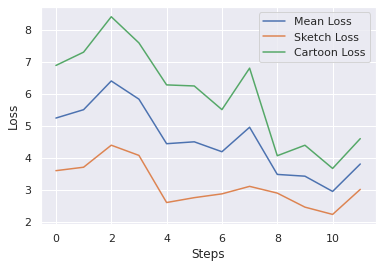

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0.24901917308679572, 0.29368708179399355, 0.2177110542331156, 0.2887203493407297, 0.28177078944785294, 0.2995555387131829, 0.29311381978931494, 0.2826313068050038, 0.23550307853477728, 0.20944286685945152, 0.2668039766434416, 0.20045597104578972]
[0.26851616187325017, 0.3130567574446424, 0.22168490710104352, 0.30440315601934337, 0.302876049885467, 0.3196742173581064, 0.30465767370832275, 0.3003308729956732, 0.23593789768388904, 0.20386866887248664, 0.24051921608551793, 0.18376177144311528]
[0.2295221843003413, 0.2743174061433447, 0.2137372013651877, 0.27303754266211605, 0.2606655290102389, 0.2794368600682594, 0.2815699658703072, 0.26493174061433444, 0.23506825938566553, 0.2150170648464164, 0.2930887372013652, 0.21715017064846417]
[5.245283337390499, 5.507175973773633, 6.4053373674331615, 5.836549268107232, 4.443372793689887, 4.502501309884299, 4.192048814518186, 4.957969611547513, 3.482802774849998, 3.427477983008051, 2.950661148151308, 3.8086996

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Starting epoch 2/15, LR = [0.001]
Starting epoch 3/15, LR = [0.001]
Starting epoch 4/15, LR = [0.001]
Starting epoch 5/15, LR = [0.001]
Starting epoch 6/15, LR = [0.001]
Starting epoch 7/15, LR = [0.001]
Starting epoch 8/15, LR = [0.001]
Starting epoch 9/15, LR = [0.001]
Starting epoch 10/15, LR = [0.001]
Starting epoch 11/15, LR = [0.001]
Starting epoch 12/15, LR = [0.001]
Starting epoch 13/15, LR = [0.001]
Starting epoch 14/15, LR = [0.001]
Starting epoch 15/15, LR = [1e-05]


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]

Test Accuracy: 0.466796875
Test Loss: 2.554388999938965
Final accuracy on art: (0.466796875, 2.554388999938965)


In [0]:
# show lineplots
outputAccuracies(steps, accuraciesMean, accuraciesSketch, accuraciesCartoon)
outputLosses(steps, lossesMean, lossesSketch, lossesCartoon)

# now 3a again -- test the model with the largest mean accuracy
print("\nDEBUG BEST MODEL:\n LR, WEIGHT_DECAY, STEP_SIZE: {}\n Accuracy mean: {} ".format(best_hparameters, best_Accuracy))
target_dataloader = art_dataloader
bestnet, optimizer, criterion = instantiateNewNet(NUM_EPOCHS, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
finalAccuracy = test(bestnet, target_dataloader, art_dataset, optimizer, criterion)
print("Final accuracy on art: {}".format(finalAccuracy))

**Point 4b**

In [0]:
# 4B => find the best parameters!
#DOMAIN_ADAPTATION = True
#training(net, NUM_EPOCHS, scheduler, optimizer, train_dataloader,test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
# now 3b again"""


LRs = [0.005] #0.01
ALPHAs = [0.1, 0.5, 0.8]
WEIGHT_DECAYs = [5e-5, 5e-4]
STEP_SIZE = 10

best_Accuracy = -1 # i will test the best scoring net, in terms of accuracy, on art
best_hparameters = (0, 0, 0)

accuraciesCartoon = []
accuraciesSketch = []
accuraciesMean = []

lossesCartoon = []
lossesSketch = []
lossesMean = []


steps = []
step = 0
for LR in LRs:
  for WEIGHT_DECAY in WEIGHT_DECAYs:
    for ALPHA in ALPHAs:
      # 4A  => find the best parameters!
      # without domain adaptation i do not need to train 2 nets,
      # yet i just have to test the same net against the 2 targets 
      # => target dataloader is not actually used if not in the test!
      DOMAIN_ADAPTATION = True

      target_dataloader = cartoon_dataloader
      bestnet, optimizer, criterion = instantiateNewNet(NUM_EPOCHS, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
      cartoonAccuracy, cartoonLoss = test(bestnet, target_dataloader, cartoon_dataset, optimizer, criterion)
      target_dataloader = sketch_dataloader
      bestnet, optimizer, criterion = instantiateNewNet(NUM_EPOCHS, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
      sketchAccuracy, sketchLoss = test(bestnet, target_dataloader, sketch_dataset, optimizer, criterion)
      meanAccuracy = (cartoonAccuracy + sketchAccuracy)/2
      meanLoss = (cartoonLoss + sketchLoss)/2
      if meanAccuracy > best_Accuracy:
        best_Accuracy = meanAccuracy
        best_hparameters = (LR, WEIGHT_DECAY, ALPHA)
      print("\nDEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): {}".format((LR, WEIGHT_DECAY,ALPHA)))
      print("\nDEBUG:\nCartoon accuracy: {}\n Sketch accuracy: {}\n Mean accuracy: {}".format(cartoonAccuracy, sketchAccuracy, meanAccuracy))

      steps.append(step)
      accuraciesMean.append(meanAccuracy)
      accuraciesSketch.append(sketchAccuracy)
      accuraciesCartoon.append(cartoonAccuracy)

      lossesMean.append(meanLoss)
      lossesSketch.append(sketchLoss)
      lossesCartoon.append(cartoonLoss)
      step = step + 1

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/15, LR = [0.005]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


Test Accuracy: 0.5149317406143344
Test Loss: 6.563478853922248
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Test Accuracy: 0.38788495800458134
Test Loss: 2.061638090075898

DEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): (0.005, 5e-05, 0.1)

DEBUG:
Cartoon accuracy: 0.5149317406143344
 Sketch accuracy: 0.38788495800458134
 Mean accuracy: 0.4514083493094579
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Test Accuracy: 0.11006825938566553
Test Loss: 3.8251456563383237
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Test Accuracy: 0.15118350725375412
Test Loss: 2.962440512082631

DEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): (0.005, 5e-05, 0.5)

DEBUG:
Cartoon accuracy: 0.11006825938566553
 Sketch accuracy: 0.15118350725375412
 Mean accuracy: 0.1306258833197098
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Test Accuracy: 0.11646757679180887
Test Loss: 2.8019139677184435
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Test Accuracy: 0.23237465003817764
Test Loss: 2.116078785279532

DEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): (0.005, 5e-05, 0.8)

DEBUG:
Cartoon accuracy: 0.11646757679180887
 Sketch accuracy: 0.23237465003817764
 Mean accuracy: 0.17442111341499325
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Test Accuracy: 0.5179180887372014
Test Loss: 4.416987656733282
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Test Accuracy: 0.19216085517943496
Test Loss: 7.944144645335566

DEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): (0.005, 0.0005, 0.1)

DEBUG:
Cartoon accuracy: 0.5179180887372014
 Sketch accuracy: 0.19216085517943496
 Mean accuracy: 0.35503947195831814
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Test Accuracy: 0.1296928327645051
Test Loss: 3.2522219765308367
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-zkopm66v'


Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-4_tq2o0w'


Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Test Accuracy: 0.2028505981165691
Test Loss: 1.7884713724145576

DEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): (0.005, 0.0005, 0.5)

DEBUG:
Cartoon accuracy: 0.1296928327645051
 Sketch accuracy: 0.2028505981165691
 Mean accuracy: 0.1662717154405371
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Test Accuracy: 0.14462457337883958
Test Loss: 3.1569836196639027
Starting epoch 1/15, LR = [0.005]
Starting epoch 2/15, LR = [0.005]
Starting epoch 3/15, LR = [0.005]
Starting epoch 4/15, LR = [0.005]
Starting epoch 5/15, LR = [0.005]
Starting epoch 6/15, LR = [0.005]
Starting epoch 7/15, LR = [0.005]
Starting epoch 8/15, LR = [0.005]
Starting epoch 9/15, LR = [0.005]
Starting epoch 10/15, LR = [0.005]
Starting epoch 11/15, LR = [5e-05]
Starting epoch 12/15, LR = [0.0005]
Starting epoch 13/15, LR = [0.0005]
Starting epoch 14/15, LR = [0.0005]
Starting epoch 15/15, LR = [0.0005]


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]

Test Accuracy: 0.21354034105370323
Test Loss: 2.093667868956199

DEBUG: parameters tested (LR, WEIGHT_DECAY, ALPHA): (0.005, 0.0005, 0.8)

DEBUG:
Cartoon accuracy: 0.14462457337883958
 Sketch accuracy: 0.21354034105370323
 Mean accuracy: 0.17908245721627142


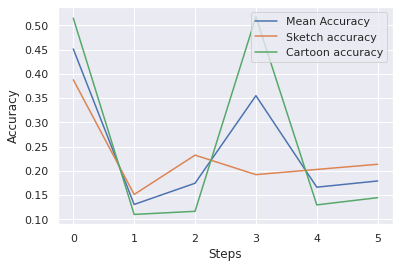

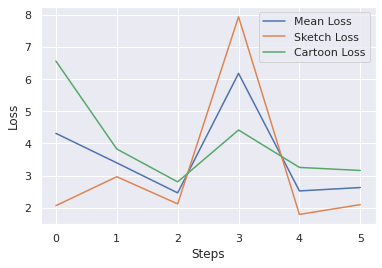

In [0]:
# show lineplots
outputAccuracies(steps, accuraciesMean, accuraciesSketch, accuraciesCartoon)
outputLosses(steps, lossesMean, lossesSketch, lossesCartoon)

In [0]:
# now 3a again -- test the model with the largest mean accuracy
print("\nDEBUG BEST MODEL:\n LR, WEIGHT_DECAY, ALPHA: {}\n Accuracy mean: {} ".format(best_hparameters, best_Accuracy))

LR = best_hparameters[0]
WEIGHT_DECAY = best_hparameters[1]
ALPHA = best_hparameters[2]
DOMAIN_ADAPTATION = False

target_dataloader = art_dataloader
bestnet, optimizer, criterion = instantiateNewNet(NUM_EPOCHS, train_dataloader, test_dataloader, target_dataloader, DOMAIN_ADAPTATION)
finalAccuracy = test(bestnet, target_dataloader, art_dataset, optimizer, criterion)

#target_dataloader = sketch_dataloader
#finalAccuracySketch = test(bestnet, target_dataloader, art_dataset, optimizer, criterion)
#target_dataloader = cartoon_dataloader
#finalAccuracyCartoon = test(bestnet, target_dataloader, art_dataset, optimizer, criterion)
#finalAccuracy = (finalAccuracySketch + finalAccuracyCartoon)/2

print("Final accuracy on art: {}".format(finalAccuracy))

In [0]:
"""steps = range(1,19)
accuraciesMean = [0.30571863460380805,0.09514857144346277,0.24783632818709572,0.3195039055001012,0.31303656107512445,0.13451878783561805,0.2519800585825015,0.32663870736285794,0.24741220442721795,0.2404625902430253,0.364707452330053,0.2937756309302404,0.314561115517153,0.24255204582708262,0.24027343929839984,0.20592690694989652,0.2555421118192629,0.11315504644296329 ]
accuraciesCartoon = [0.38822525597269625,0.1348122866894198,0.27602389078498296,0.47738907849829354,0.3361774744027304,0.10665529010238908,0.22653583617747441,0.3310580204778157,0.33575085324232085,0.2785836177474403,0.4718430034129693,0.33532423208191126,0.23080204778156996,0.2674914675767918,0.21203071672354948,0.23165529010238908,0.24104095563139932,0.09726962457337884]
accuraciesSketch= [0.22321201323491982,0.055484856197505726,0.21964876558920846,0.1616187325019089,0.28989564774751847,0.16238228556884704,0.27742428098752864,0.32221939424790025,0.15907355561211503,0.20234156273861034,0.2575719012471367,0.2522270297785696,0.39832018325273605,0.2176126240773734,0.26851616187325017,0.18019852379740392,0.27004326800712647,0.12904046831254773]
"""